In [1]:
import os
import math
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [138]:
# установите параметры кластера

# сколько хотите задействовать excecutors (в примере: 300)
# ед. - штук
max_executor = 300            

# количествол узлов в кластере
# ед. - штук
nodes = 50
nodes = nodes - 1  

# количество процессоров на кластере (сумма по всем нодам) (в примере: вы будете использовать 1/3 от кластера)
# ед. - штук
cpu = 800
cpu = int((cpu - 1) / 3)

# количество ОЗУ на кластере (в примере: вы будете использовать 1/3 от кластера)
# ед. - мегабайт
memo = 1048576
memo = int((memo - 1024) / 3)

# установите коэффициент
overhead_coef = 0.1

# кол-во параллеризма - базовое количество партиций в RDD
parallelizm_per_core = 5

# фактор партиционирования в hdfs
partition_factor = 3

In [167]:
# создаем DataFrame с установкой параметров
df = pd.DataFrame(dict(executors=np.arange(1, max_executor)))
df['total_memo_per_executor'] = np.floor(memo / df.executors)
df['unused_memo_per_node'] = memo - (df.executors * df['total_memo_per_executor'])
df['total_core_per_executor'] = np.floor(cpu / df.executors)
df['unused_core_per_nodes'] = cpu - (df.executors * df['total_core_per_executor'])
df['overhead_memo'] = (df['total_memo_per_executor'] * overhead_coef)
df['executor_memo'] = df['total_memo_per_executor'] - df['overhead_memo']
df['executor_cores'] = np.floor(cpu / df.executors)
df['executor_instance'] = (df.executors - nodes) - 1
df['parallelism'] = df['executor_instance'] * df['executor_cores'] * parallelizm_per_core
df['num_partitions'] = df['executor_instance'] * df['executor_cores'] * partition_factor
df['unused_resurses_sum'] = df['unused_memo_per_node'] + df['unused_core_per_nodes']

# % используемой памяти на кластере
df['used_memo_persentage'] = (1- ((df['overhead_memo'] + df['executor_memo']) / memo)) * 100
# % использумых процессоров на кластере
df['used_cpu_persentage'] = ((cpu - df['unused_core_per_nodes']) / cpu) * 100


df.head(5)

,executors,total_memo_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,unused_resurses_sum,used_memo_persentage,used_cpu_persentage
0,1,349184.0,0.0,266.0,0.0,34918.4,314265.6,266.0,-49,-65170.0,-39102.0,0.0,0.000000,100.00000
1,2,174592.0,0.0,133.0,0.0,17459.2,157132.8,133.0,-48,-31920.0,-19152.0,0.0,50.000000,100.00000
2,3,116394.0,2.0,88.0,2.0,11639.4,104754.6,88.0,-47,-20680.0,-12408.0,4.0,66.666858,99.24812
3,4,87296.0,0.0,66.0,2.0,8729.6,78566.4,66.0,-46,-15180.0,-9108.0,2.0,75.000000,99.24812
4,5,69836.0,4.0,53.0,1.0,6983.6,62852.4,53.0,-45,-11925.0,-7155.0,5.0,80.000229,99.62406


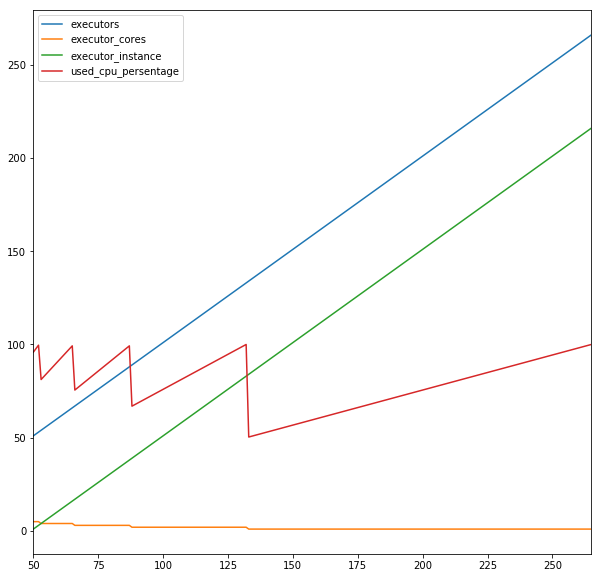

In [170]:
# посмотрим на графике распределение ресурсов
(df[(df['used_memo_persentage'] > 0)    & \
    (df['used_cpu_persentage'] > 0)     & \
    (df['used_memo_persentage'] <= 100) & \
    (df['used_cpu_persentage'] <= 100)  & \
    (df['executor_instance'] > 0)       & \
    (df['parallelism'] > 0)             & \
    (df['num_partitions'] > 0)          
    ])[['executors', 
        'executor_cores', 
        'executor_instance',
        'used_cpu_persentage'
       ]].plot(figsize=(10,10))
 

  

In [171]:
# установите количество используйемой памяти и процессоров
# например: в расчете вы использовали 1/3 от доступных ресурсов (так как вас 3 человека на кластере)
# сделайте выбор всех доступных вам ресурсов

df_opt = df[(df['used_memo_persentage'] == df['used_memo_persentage'].max())]
df_opt.head()

# вы видете, что кол-во ЦПУ = 4900, это из-за того, что вы поставили много executo

,executors,total_memo_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,unused_resurses_sum,used_memo_persentage,used_cpu_persentage
298,299,1167.0,251.0,0.0,266.0,116.7,1050.3,0.0,249,0.0,0.0,517.0,99.665792,0.0


In [172]:
# сделаем выбор по другим фильтрам
# executor_instance
# parallelism
# num_partitions
# установим максимальное использование выделенных ресурсов.

df_opt = df[(df['executor_instance'] > 0)       & \
            (df['parallelism'] > 0)             & \
            (df['num_partitions'] > 0)]

df_opt = df_opt[(df_opt['used_memo_persentage'] == df_opt['used_memo_persentage'].max())]
df_opt


,executors,total_memo_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,unused_resurses_sum,used_memo_persentage,used_cpu_persentage
265,266,1312.0,192.0,1.0,0.0,131.2,1180.8,1.0,216,1080.0,648.0,192.0,99.624267,100.0


In [174]:
exMemoryOverhead = df['overhead_memo']
exMemory = df['executor_memo']
drMemoryOverhead = df['overhead_memo']
drMemory = df['executor_memo']
drMaxResultSize = df['executor_memo']
exCores = df['executor_cores']
drCores = df['executor_cores']
defParallelism = df['parallelism']